In [1]:
import tweepy
import pandas as pd
from textblob import TextBlob
from datetime import datetime
import time
from ast import literal_eval
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import sys
sys.path.insert(1, 'C:\\Users\\raide\\OneDrive\\Documents\\GitHub\\capstone_project\\scraping')
sys.path.insert(1, 'C:\\Users\\raide\\OneDrive\\Documents\\GitHub\\capstone_project\\constants')
from scrape_hashtags import get_hashtag_stats
from constants import get_matteo_twitter_creds, get_michael_twitter_creds

In [2]:
abspath_curr = os.path.join(os.getcwd())
data_path = os.path.join(abspath_curr, 'data')

## Prepare and run scrape

In [3]:
def scrape_tweets(api, search_word, num_tweets, num_runs, run_path=None):

    import os
    import time
    from datetime import datetime
    
    today = datetime.today().strftime('%Y-%m-%d')
    columns = ['created_time', 'tweet_id', 'handle_name', 'name', 'location', 'tweet_text', 'favorite_count', 'retweet_count', 'replied_tweet_screen_name_str', 'quote_tweet_bool', 'hashtags', 'geo']
    df = pd.DataFrame(columns=columns)
    program_start = time.time()
    for i in range(0, num_runs):
        start_time = time.time()
        tweets = tweepy.Cursor(api.search_tweets, q=search_word, lang='en', until=today).items(num_tweets)
        tweets = [tweet for tweet in tweets]

        count = 0
        for tweet in tweets:
            created_time = tweet.created_at
            tweet_id = tweet.id
            handle_name = tweet.user._json['screen_name']
            name = tweet.user._json['name']
            location = tweet.user.location
            tweet_text = tweet.text
            favorite_count = tweet.favorite_count
            retweet_count = tweet.retweet_count
            replied_tweet_screen_name_str = tweet.in_reply_to_screen_name 
            quote_tweet_bool = tweet.is_quote_status
            hashtags = tweet.entities['hashtags']
            geo = tweet.geo

            ith_tweet = [created_time, tweet_id, handle_name, name, location, tweet_text, favorite_count, retweet_count, replied_tweet_screen_name_str, quote_tweet_bool, hashtags, geo]
            df.loc[len(df)] = ith_tweet
            count +=1
        
        to_csv_timestamp = datetime.today().strftime('%Y%m%d_%H%M%S_')
        filename = os.path.join(run_path, to_csv_timestamp + 'exposed_food_scrape_tweets.csv')
        df.to_csv(filename, index=False)
        program_end = time.time()
        end_run = time.time()
        duration_run = round((end_run-start_time)/60, 2)
        
        print('no. of tweets scraped for run {} is {}'.format(i + 1, count))
        print('time take for {} run to complete is {} mins'.format(i+1, duration_run))
        # time.sleep(920)
    
    # df['sentiment'] = df.tweet_text.apply(lambda x: TextBlob(x).sentiment[0])
    print('Scraping has completed!')
    print('Total time taken to scrape is {} minutes.'.format(round(program_end - program_start)/60, 2))
    
    return df

In [10]:
def scrape_query(hashtag_list, food_list, cutoff):
    """
    Calls scraping function `get_hashtag_stats` and adds supplied list of hashtags to the query for hashtag statistics. Returns a list of words whose hashtags (i.e., input 'python', check stats for '#python') have received >100K views in the last hour.
    
    Parameters:
    -----------
    hashtag_list (list): A list of strings of hashtags to get statistics on.
    
    Returns:
    --------
    exposed_hashtag_words (list): A list of strings of words where the hashtag of that word received >100K views in the past hour.
    """
    
    # Scrape for hashtags
    df = get_hashtag_stats(hashtags=hashtag_list, food_list=food_list)
    
    # Extract words and words as hashtags
    all_words = df.hashtag.tolist()
    all_hashtags = ['#' + s for s in all_words]
    
    # Filter hashtags by those that have been viewed more than the cutoff times in the past hour AND include those that we specified
    exposed_hashtags = df[(df.views_per_hour >= cutoff) | (df.hashtag.isin(hashtag_list))]
    exposed_hashtags_scrape_list = ['#' + s + ' OR 'if i != len(all_words) - 1 else '#' + s for i, s in enumerate(all_words)]
    exposed_search_words = "".join(exposed_hashtags_scrape_list)
    print(f"Out of the {df.shape[0]} hashtags in the raw data, {exposed_hashtags.shape[0]} received >= {cutoff} views.")
    
    return exposed_search_words, exposed_hashtags_scrape_list

In [11]:
def scrape_twitter(api, hashtag_list, food_list, cutoff, num_tweets, num_runs, loops):
    # Create directory to save the runs to
    abspath = os.getcwd()
    data_path = os.path.join(abspath, 'data')
    run_begin_time = datetime.today().strftime('%Y%m%d_%H%M%S_')
    run_path = os.path.join(data_path, run_begin_time + 'run')
    os.mkdir(run_path)
    
    # Loop to run for however many repeats over time set in time_limit
    for loop in range(0, loops):
        exposed_search_words, exposed_hashtags_scrape_list = scrape_query(hashtag_list=hashtag_list, food_list=food_list, cutoff=cutoff)
        scrape_tweets(api, exposed_search_words, num_tweets, num_runs, run_path)

    return

In [12]:
access_token, access_token_secret, consumer_key, consumer_secret = get_michael_twitter_creds()

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [13]:
hashtag_list=['foodie', 'foodporn', 'food', 'delicious', 'love', 'recipes', 'eating', 'recipe', 'cook', 'cooking', 'restaurant', 'vegan', 'breakfast', 'lunch', 'foodgasm', 'foodies', 'nomnomnom', 'dinner']

In [15]:
# Scrape tweets (can only scrape 500 characters at at time)
scrape_twitter(api=api, hashtag_list=hashtag_list, food_list = False, cutoff=10000, num_tweets=2500, num_runs=10, loops=10) 

Out of the 18 hashtags in the raw data, 18 received >= 10000 views.
no. of tweets scraped for run 1 is 2500
time take for 1 run to complete is 0.9 mins


Rate limit reached. Sleeping for: 844


no. of tweets scraped for run 2 is 2500
time take for 2 run to complete is 14.97 mins


Rate limit reached. Sleeping for: 844


no. of tweets scraped for run 3 is 2500
time take for 3 run to complete is 15.08 mins


Rate limit reached. Sleeping for: 837


no. of tweets scraped for run 4 is 2500
time take for 4 run to complete is 14.98 mins


Rate limit reached. Sleeping for: 837


no. of tweets scraped for run 5 is 2500
time take for 5 run to complete is 15.12 mins


Rate limit reached. Sleeping for: 829


no. of tweets scraped for run 6 is 2500
time take for 6 run to complete is 14.99 mins


Rate limit reached. Sleeping for: 827


no. of tweets scraped for run 7 is 2500
time take for 7 run to complete is 14.96 mins


Rate limit reached. Sleeping for: 827


no. of tweets scraped for run 8 is 2500
time take for 8 run to complete is 15.0 mins


Rate limit reached. Sleeping for: 826


no. of tweets scraped for run 9 is 2500
time take for 9 run to complete is 14.99 mins


Rate limit reached. Sleeping for: 825


no. of tweets scraped for run 10 is 2500
time take for 10 run to complete is 14.98 mins
Scraping has completed!
Total time taken to scrape is 135.96666666666667 minutes.
Out of the 18 hashtags in the raw data, 18 received >= 10000 views.


Rate limit reached. Sleeping for: 814


no. of tweets scraped for run 1 is 2500
time take for 1 run to complete is 14.58 mins


Rate limit reached. Sleeping for: 839


no. of tweets scraped for run 2 is 2500
time take for 2 run to complete is 15.02 mins


Rate limit reached. Sleeping for: 835


no. of tweets scraped for run 3 is 2500
time take for 3 run to complete is 14.96 mins


Rate limit reached. Sleeping for: 836


no. of tweets scraped for run 4 is 2500
time take for 4 run to complete is 14.95 mins


Rate limit reached. Sleeping for: 837


no. of tweets scraped for run 5 is 2500
time take for 5 run to complete is 14.99 mins


Rate limit reached. Sleeping for: 836


no. of tweets scraped for run 6 is 2500
time take for 6 run to complete is 14.98 mins


Rate limit reached. Sleeping for: 834


no. of tweets scraped for run 7 is 2500
time take for 7 run to complete is 14.97 mins


Rate limit reached. Sleeping for: 835


no. of tweets scraped for run 8 is 2500
time take for 8 run to complete is 15.0 mins


Rate limit reached. Sleeping for: 835


no. of tweets scraped for run 9 is 2500
time take for 9 run to complete is 14.99 mins


Rate limit reached. Sleeping for: 832


no. of tweets scraped for run 10 is 2500
time take for 10 run to complete is 15.04 mins
Scraping has completed!
Total time taken to scrape is 149.5 minutes.
Out of the 18 hashtags in the raw data, 18 received >= 10000 views.


Rate limit reached. Sleeping for: 819


no. of tweets scraped for run 1 is 2500
time take for 1 run to complete is 14.57 mins


Rate limit reached. Sleeping for: 843


no. of tweets scraped for run 2 is 2500
time take for 2 run to complete is 14.98 mins


Rate limit reached. Sleeping for: 842


no. of tweets scraped for run 3 is 2500
time take for 3 run to complete is 14.99 mins
no. of tweets scraped for run 4 is 2500
time take for 4 run to complete is 0.92 mins


Rate limit reached. Sleeping for: 831


no. of tweets scraped for run 5 is 2500
time take for 5 run to complete is 14.85 mins


Rate limit reached. Sleeping for: 838


no. of tweets scraped for run 6 is 2500
time take for 6 run to complete is 15.01 mins


Rate limit reached. Sleeping for: 837


no. of tweets scraped for run 7 is 2500
time take for 7 run to complete is 15.0 mins


Rate limit reached. Sleeping for: 835


no. of tweets scraped for run 8 is 2500
time take for 8 run to complete is 14.96 mins


Rate limit reached. Sleeping for: 836


no. of tweets scraped for run 9 is 2500
time take for 9 run to complete is 14.98 mins


Rate limit reached. Sleeping for: 836


no. of tweets scraped for run 10 is 2500
time take for 10 run to complete is 14.99 mins
Scraping has completed!
Total time taken to scrape is 135.26666666666668 minutes.
Out of the 18 hashtags in the raw data, 18 received >= 10000 views.


Rate limit reached. Sleeping for: 824


no. of tweets scraped for run 1 is 2500
time take for 1 run to complete is 14.62 mins


Rate limit reached. Sleeping for: 845


no. of tweets scraped for run 2 is 2500
time take for 2 run to complete is 14.98 mins


Rate limit reached. Sleeping for: 845


no. of tweets scraped for run 3 is 2500
time take for 3 run to complete is 14.98 mins


Rate limit reached. Sleeping for: 845


no. of tweets scraped for run 4 is 2500
time take for 4 run to complete is 15.0 mins


Rate limit reached. Sleeping for: 843


no. of tweets scraped for run 5 is 2500
time take for 5 run to complete is 15.0 mins


Rate limit reached. Sleeping for: 842


no. of tweets scraped for run 6 is 2500
time take for 6 run to complete is 15.01 mins


Rate limit reached. Sleeping for: 839


no. of tweets scraped for run 7 is 2500
time take for 7 run to complete is 14.99 mins


Rate limit reached. Sleeping for: 839


no. of tweets scraped for run 8 is 2500
time take for 8 run to complete is 15.0 mins


Rate limit reached. Sleeping for: 838


no. of tweets scraped for run 9 is 2500
time take for 9 run to complete is 15.05 mins


Rate limit reached. Sleeping for: 834


no. of tweets scraped for run 10 is 2500
time take for 10 run to complete is 14.98 mins
Scraping has completed!
Total time taken to scrape is 149.6 minutes.
Out of the 18 hashtags in the raw data, 18 received >= 10000 views.


Rate limit reached. Sleeping for: 823


no. of tweets scraped for run 1 is 2500
time take for 1 run to complete is 14.59 mins


Rate limit reached. Sleeping for: 846


no. of tweets scraped for run 2 is 2500
time take for 2 run to complete is 14.99 mins


Rate limit reached. Sleeping for: 845


no. of tweets scraped for run 3 is 2500
time take for 3 run to complete is 15.0 mins


Rate limit reached. Sleeping for: 844


no. of tweets scraped for run 4 is 2500
time take for 4 run to complete is 15.0 mins


Rate limit reached. Sleeping for: 842


no. of tweets scraped for run 5 is 2500
time take for 5 run to complete is 14.99 mins


Rate limit reached. Sleeping for: 841


no. of tweets scraped for run 6 is 2500
time take for 6 run to complete is 14.99 mins


Rate limit reached. Sleeping for: 840


no. of tweets scraped for run 7 is 2500
time take for 7 run to complete is 15.01 mins


Rate limit reached. Sleeping for: 836


no. of tweets scraped for run 8 is 2500
time take for 8 run to complete is 14.99 mins
no. of tweets scraped for run 9 is 2500
time take for 9 run to complete is 1.02 mins


Rate limit reached. Sleeping for: 817


no. of tweets scraped for run 10 is 2500
time take for 10 run to complete is 14.68 mins
Scraping has completed!
Total time taken to scrape is 135.26666666666668 minutes.
Out of the 18 hashtags in the raw data, 18 received >= 10000 views.


Rate limit reached. Sleeping for: 824


no. of tweets scraped for run 1 is 2500
time take for 1 run to complete is 14.58 mins


Rate limit reached. Sleeping for: 847


no. of tweets scraped for run 2 is 2500
time take for 2 run to complete is 14.98 mins


Rate limit reached. Sleeping for: 846


no. of tweets scraped for run 3 is 2500
time take for 3 run to complete is 15.01 mins


Rate limit reached. Sleeping for: 843


no. of tweets scraped for run 4 is 2500
time take for 4 run to complete is 14.95 mins


Rate limit reached. Sleeping for: 845


no. of tweets scraped for run 5 is 2500
time take for 5 run to complete is 15.0 mins


Rate limit reached. Sleeping for: 843


no. of tweets scraped for run 6 is 2500
time take for 6 run to complete is 14.99 mins


Rate limit reached. Sleeping for: 842


no. of tweets scraped for run 7 is 2500
time take for 7 run to complete is 14.98 mins


Rate limit reached. Sleeping for: 841


no. of tweets scraped for run 8 is 2500
time take for 8 run to complete is 14.97 mins


Rate limit reached. Sleeping for: 842


no. of tweets scraped for run 9 is 2500
time take for 9 run to complete is 15.02 mins


Rate limit reached. Sleeping for: 838


no. of tweets scraped for run 10 is 2500
time take for 10 run to complete is 14.98 mins
Scraping has completed!
Total time taken to scrape is 149.46666666666667 minutes.
Out of the 18 hashtags in the raw data, 18 received >= 10000 views.


Rate limit reached. Sleeping for: 827


no. of tweets scraped for run 1 is 2500
time take for 1 run to complete is 14.66 mins


Rate limit reached. Sleeping for: 848


no. of tweets scraped for run 2 is 2500
time take for 2 run to complete is 15.04 mins


Rate limit reached. Sleeping for: 846


no. of tweets scraped for run 3 is 2500
time take for 3 run to complete is 15.01 mins


Rate limit reached. Sleeping for: 848


no. of tweets scraped for run 4 is 2500
time take for 4 run to complete is 15.05 mins


Rate limit reached. Sleeping for: 845


no. of tweets scraped for run 5 is 2500
time take for 5 run to complete is 15.05 mins


Rate limit reached. Sleeping for: 842


no. of tweets scraped for run 6 is 2500
time take for 6 run to complete is 15.01 mins


Rate limit reached. Sleeping for: 843


no. of tweets scraped for run 7 is 2500
time take for 7 run to complete is 15.03 mins


Rate limit reached. Sleeping for: 841


no. of tweets scraped for run 8 is 2500
time take for 8 run to complete is 15.02 mins


Rate limit reached. Sleeping for: 840


no. of tweets scraped for run 9 is 2500
time take for 9 run to complete is 15.04 mins


Rate limit reached. Sleeping for: 838


no. of tweets scraped for run 10 is 2500
time take for 10 run to complete is 15.02 mins
Scraping has completed!
Total time taken to scrape is 149.93333333333334 minutes.
Out of the 18 hashtags in the raw data, 18 received >= 10000 views.


Rate limit reached. Sleeping for: 827


no. of tweets scraped for run 1 is 2500
time take for 1 run to complete is 14.67 mins


Rate limit reached. Sleeping for: 847


no. of tweets scraped for run 2 is 2500
time take for 2 run to complete is 15.02 mins


Rate limit reached. Sleeping for: 846


no. of tweets scraped for run 3 is 2500
time take for 3 run to complete is 15.02 mins


Rate limit reached. Sleeping for: 846


no. of tweets scraped for run 4 is 2500
time take for 4 run to complete is 15.03 mins


Rate limit reached. Sleeping for: 844


no. of tweets scraped for run 5 is 2500
time take for 5 run to complete is 15.01 mins


Rate limit reached. Sleeping for: 844


no. of tweets scraped for run 6 is 2500
time take for 6 run to complete is 15.04 mins


Rate limit reached. Sleeping for: 842


no. of tweets scraped for run 7 is 2500
time take for 7 run to complete is 15.02 mins


Rate limit reached. Sleeping for: 841


no. of tweets scraped for run 8 is 2500
time take for 8 run to complete is 15.04 mins


Rate limit reached. Sleeping for: 840


no. of tweets scraped for run 9 is 2500
time take for 9 run to complete is 15.03 mins


Rate limit reached. Sleeping for: 838


no. of tweets scraped for run 10 is 2500
time take for 10 run to complete is 15.02 mins
Scraping has completed!
Total time taken to scrape is 149.9 minutes.
Out of the 18 hashtags in the raw data, 18 received >= 10000 views.


Rate limit reached. Sleeping for: 827


no. of tweets scraped for run 1 is 2500
time take for 1 run to complete is 14.67 mins


Rate limit reached. Sleeping for: 847


no. of tweets scraped for run 2 is 2500
time take for 2 run to complete is 15.04 mins


Rate limit reached. Sleeping for: 845


no. of tweets scraped for run 3 is 2500
time take for 3 run to complete is 15.03 mins


Rate limit reached. Sleeping for: 843


no. of tweets scraped for run 4 is 2500
time take for 4 run to complete is 15.01 mins


Rate limit reached. Sleeping for: 844


no. of tweets scraped for run 5 is 2500
time take for 5 run to complete is 15.04 mins


Rate limit reached. Sleeping for: 842


no. of tweets scraped for run 6 is 2500
time take for 6 run to complete is 15.03 mins


Rate limit reached. Sleeping for: 841


no. of tweets scraped for run 7 is 2500
time take for 7 run to complete is 15.04 mins


Rate limit reached. Sleeping for: 839


no. of tweets scraped for run 8 is 2500
time take for 8 run to complete is 15.02 mins


Rate limit reached. Sleeping for: 838


no. of tweets scraped for run 9 is 2500
time take for 9 run to complete is 15.01 mins


Rate limit reached. Sleeping for: 838


no. of tweets scraped for run 10 is 2500
time take for 10 run to complete is 15.05 mins
Scraping has completed!
Total time taken to scrape is 149.93333333333334 minutes.
Out of the 18 hashtags in the raw data, 18 received >= 10000 views.


Rate limit reached. Sleeping for: 825


no. of tweets scraped for run 1 is 2500
time take for 1 run to complete is 14.68 mins


Rate limit reached. Sleeping for: 845


no. of tweets scraped for run 2 is 2500
time take for 2 run to complete is 15.02 mins


Rate limit reached. Sleeping for: 844


no. of tweets scraped for run 3 is 2500
time take for 3 run to complete is 15.03 mins


Rate limit reached. Sleeping for: 843


no. of tweets scraped for run 4 is 2500
time take for 4 run to complete is 15.03 mins


Rate limit reached. Sleeping for: 842


no. of tweets scraped for run 5 is 2500
time take for 5 run to complete is 15.03 mins


Rate limit reached. Sleeping for: 840


no. of tweets scraped for run 6 is 2500
time take for 6 run to complete is 14.99 mins


Rate limit reached. Sleeping for: 842


no. of tweets scraped for run 7 is 2500
time take for 7 run to complete is 15.08 mins


Rate limit reached. Sleeping for: 836


no. of tweets scraped for run 8 is 2500
time take for 8 run to complete is 15.03 mins


Rate limit reached. Sleeping for: 838


no. of tweets scraped for run 9 is 2500
time take for 9 run to complete is 15.08 mins


Rate limit reached. Sleeping for: 835


no. of tweets scraped for run 10 is 2500
time take for 10 run to complete is 15.02 mins
Scraping has completed!
Total time taken to scrape is 149.98333333333332 minutes.


In [4]:
def stitch_frames(data_path):
    frames = []
    for subdir, dirs, files in os.walk(data_path):
        for file in files:
            if subdir.endswith('scrape_run') and file.endswith('tweets.csv'):
                path = os.path.join(subdir, file)
                df = pd.read_csv(path, index_col=None, header=0)
                frames.append(df)
    df = pd.concat(frames, axis=0, ignore_index=True)
    return df

In [18]:
def clean_data():
    # Read in data
    df = stitch_frames(data_path)

    # Expand list of hashtag dictionaries
    df.hashtags = df.hashtags.apply(literal_eval)
    df = df.explode('hashtags').reset_index(drop=True)

    # Drop nas
    df = df.dropna(subset=['hashtags']).reset_index(drop=True)

    # Flatten hashtag dictionaries
    df = pd.json_normalize(df.to_dict(orient='records'), sep='_')

    # Only keep rows that have the hashtags we searched for
    df = df[df['hashtags_text'].isin(hashtag_list)].reset_index(drop=True)
    # df = df[df['hashtag'].isin(exposed_hashtags_list)]
    # df = df[df['hashtag'].isin(less_exposed_hashtags_list)]
    # df = df[df['hashtag'].isin(all_hashtags)]

    # Drop string nans
    df = df[df['hashtags_text'] != 'nan']

    # Remove emojis
    df = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

    # Add sentiment column
    df['sentiment'] = df.tweet_text.apply(lambda x: TextBlob(x).sentiment[0])

    # Change columns to numeric
    df[['tweet_id', 'favorite_count', 'retweet_count', 'sentiment']] = df[['tweet_id', 'favorite_count', 'retweet_count', 'sentiment']].apply(pd.to_numeric)

    # Write to directory
    to_csv_timestamp = datetime.today().strftime('%Y%m%d_%H%M%S_')
    file_name = os.path.join(data_path, to_csv_timestamp + 'clean_scraping_custom_hashtags_data.csv')
    df.to_csv(file_name, encoding='utf-8-sig')
    return df

In [23]:
clean_data()

,created_time,tweet_id,handle_name,name,location,tweet_text,favorite_count,retweet_count,replied_tweet_screen_name_str,quote_tweet_bool,geo,hashtags_text,hashtags_indices,sentiment
0,2021-10-25 23:59:46+00:00,1452786996385132544,MoonluBoutique,Moonlu Boutique,nan,#hair #specialists #wigs #extensions #eyelashe...,0,0,nan,False,nan,love,"[88, 93]",0.350000
1,2021-10-25 23:59:23+00:00,1452786900562071552,veganfuture,Vegan Future,nan,RT @Rachael57354278: In the ways that matter w...,0,24,nan,False,nan,love,"[69, 74]",0.250000
2,2021-10-25 23:59:23+00:00,1452786900562071552,veganfuture,Vegan Future,nan,RT @Rachael57354278: In the ways that matter w...,0,24,nan,False,nan,vegan,"[109, 115]",0.250000
3,2021-10-25 23:59:02+00:00,1452786812250849280,SallyHuss,Sally Huss,"Colorado Springs, CO",RT @SallyHuss: A book for every child\nhttps:/...,0,1,nan,False,nan,love,"[83, 88]",0.500000
4,2021-10-25 23:59:00+00:00,1452786803988213760,exceptionalfood,Gourmet Delights,nan,Canded Pears \n\nhttps://t.co/3R1BeX6boq\n\n#M...,0,0,nan,False,nan,foodies,"[56, 64]",0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224683,2021-10-25 22:58:13+00:00,1452771508670042113,JoseMat55691069,Jose Mateo,nan,"From mac and cheese to sloppy joes, these reci...",0,0,nan,False,nan,delicious,"[84, 94]",0.291667
224684,2021-10-25 22:58:12+00:00,1452771505893429250,drewbrews,drew froning,"Kent, OH, USA",Breakfast at Jammin Crepes in Princeton #delic...,0,0,nan,False,"{'type': 'Point', 'coordinates': [40.349007, -...",delicious,"[41, 51]",1.000000
224685,2021-10-25 22:58:11+00:00,1452771499102855172,brunetteblondez,Munchkin,nan,All I want is love that last is there somethin...,0,0,nan,False,nan,love,"[62, 67]",0.125000
224686,2021-10-25 22:58:06+00:00,1452771477879549953,Caruth_Convos,Caruth Conversations,"San Diego, CA",https://t.co/uhh7lGSIBe Quotes from our upcomi...,0,0,nan,False,nan,love,"[72, 77]",0.500000


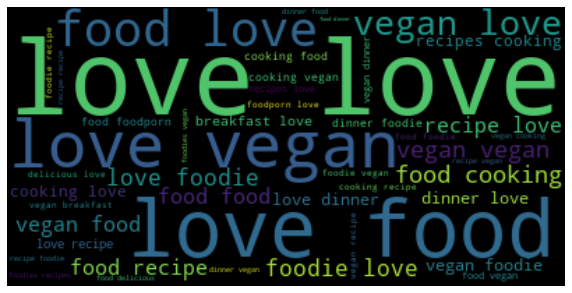

In [5]:
# Get string of hashtags
text = " ".join(hashtag for hashtag in df.hashtags_text)

# Generate wordcloud image
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, max_font_size=100, max_words=100, background_color="black", mode="RGBA").generate(text)

# Display wordcloud image
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
image_path = r'C:\Users\raide\OneDrive\Documents\GitHub\capstone_project\images'
data_files = [f.rsplit('.', 1)[0] for f in listdir(data_path) if isfile(join(data_path, f))]
# plt.savefig(image_path + '//' + data_files[-1] + '.png', format="png")
plt.show()

In [6]:
def sentiment_hist(df):

    # Create plot
    sns.set_theme(style="darkgrid")
    sns.histplot(data=df, x="sentiment", bins=75, hue='pos_neg')
    plt.legend(title='Sentiment', labels=['Negative', 'Neutral', 'Positive'])
    plt.figure(figsize=[10,10])
    
    # Save image
    image_path = os.path.join(abspath_curr, 'images')
    to_csv_timestamp = datetime.today().strftime('%Y%m%d_%H%M%S_')
    image_file_path = os.path.join(image_path, to_csv_timestamp + 'clean_hashtag_streaming_custom_hashtag_sentiment.png')
    # plt.savefig(image_file_path, format="png")
    
    return 

In [4]:
df = pd.read_csv(r'C:\Users\raide\OneDrive\Documents\GitHub\capstone_project\tweepy\data\20211026_195518_clean_scraping_custom_hashtags_data.csv', index_col=0)
df.head()

,created_time,tweet_id,handle_name,name,location,tweet_text,favorite_count,retweet_count,replied_tweet_screen_name_str,quote_tweet_bool,geo,hashtags_text,hashtags_indices,sentiment
0,2021-10-25 23:59:46+00:00,1452786996385132544,MoonluBoutique,Moonlu Boutique,NaN,#hair #specialists #wigs #extensions #eyelashe...,0,0,NaN,False,NaN,love,"[88, 93]",0.35
1,2021-10-25 23:59:23+00:00,1452786900562071552,veganfuture,Vegan Future,NaN,RT @Rachael57354278: In the ways that matter w...,0,24,NaN,False,NaN,love,"[69, 74]",0.25
2,2021-10-25 23:59:23+00:00,1452786900562071552,veganfuture,Vegan Future,NaN,RT @Rachael57354278: In the ways that matter w...,0,24,NaN,False,NaN,vegan,"[109, 115]",0.25
3,2021-10-25 23:59:02+00:00,1452786812250849280,SallyHuss,Sally Huss,"Colorado Springs, CO",RT @SallyHuss: A book for every child\nhttps:/...,0,1,NaN,False,NaN,love,"[83, 88]",0.50
4,2021-10-25 23:59:00+00:00,1452786803988213760,exceptionalfood,Gourmet Delights,NaN,Canded Pears \n\nhttps://t.co/3R1BeX6boq\n\n#M...,0,0,NaN,False,NaN,foodies,"[56, 64]",0.00


In [10]:
# Add sentiment pos/neg column
df['pos_neg'] = df.sentiment.apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

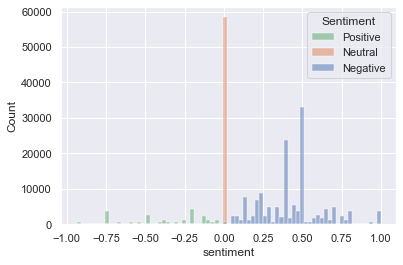

<Figure size 720x720 with 0 Axes>

In [11]:
sentiment_hist(df)